In [496]:
from bs4 import BeautifulSoup
import re
import json
import requests
import time
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import defaultdict
from copy import deepcopy
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.cross_validation import KFold
from sklearn import linear_model, tree, ensemble
from sklearn.metrics import mean_squared_error
import seaborn as sns
import itertools
import diagnostic_plots as dp_plot
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from geopy.geocoders import Nominatim

plt.rc('figure', figsize=(16.0, 10.0))
plt.style.use('fivethirtyeight')
% matplotlib inline

In [525]:
class Restaurant:
    
    def __init__(self, json):
        self.Name = json['name']
        self.Geo = json['geo']
        self.Types = json['servesCuisine']
        self.Menudf = create_menudf(json, json['name'])
        
    def get_coordinates(self):
        coords = (self.Geo['latitude'], self.Geo['longitude'])
        return coords
    
# Scraping Functions
def gather_allmenus_links(restaurant_type):

    major_url = f'https://www.allmenus.com/ca/san-francisco/-/{restaurant_type.lower()}/'
    major_r = requests.get(major_url).text
    major_soup = BeautifulSoup(major_r, 'html5lib')
    major_parent = major_soup.find_all('section', class_ = 'restaurant-list-container s-col-md-8')[0]
    r_list = major_parent.find_all('li', class_  = 'restaurant-list-item clearfix')
    
    url_list = []
    for link in r_list:
        r_url = link.find('a')
        url_list.append(f'https://www.allmenus.com{r_url.get("href")}')
    
    return set(url_list)


def scrape_json(url):
    
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    parent = soup.find_all('head')[0]
    children = parent.find_all("script")
    menu_child = children[1]
    json_html = re.sub(r'\r|\n', '', menu_child.text)
    return json.loads(json_html)

# Interpreting Data Functions
def get_dish_features(entry, name_list, desc_list, price_list):
    
    name_list.append(entry['name'])
    desc_list.append(entry['description'])
    # This is to catch entries missing price
    try:
        offers_list = entry['offers']
        first_offer = offers_list[0]
        price_list.append(first_offer['Price'])
    except:
        price_list.append(None)

def create_menudf(json, Res_Name):
    
    total_df = pd.DataFrame(columns = ['Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc', 'Dish Price'])
    
    try:
        menu_info = json['hasMenu'][0]
    except IndexError:
        print(f'No Menu for {Res_Name}')
        return None

    for MenuSections in menu_info['hasMenuSection']:

        # Holding name and description for each menu section
        MenuSectionName = MenuSections['name']
        MenuSectionDesc = MenuSections['description']

        # Lists that get_dish_features will be appending to
        ItemNames = []
        ItemDescs = []
        ItemPrices = []

        for Dish in MenuSections['hasMenuItem']:
            get_dish_features(Dish, ItemNames, ItemDescs, ItemPrices)

        section_df = pd.DataFrame({'Menu Section': MenuSectionName,
                                   'Menu Section Desc': MenuSectionDesc,
                                   'Dish Name': ItemNames,
                                   'Dish Desc': ItemDescs,
                                   'Dish Price': ItemPrices})

        total_df = total_df.append(section_df)

    total_df = total_df.reset_index(drop = True)
    return total_df

# Packaging Functions
def create_rest_pkl(types_list, x, filename):
    
    restaurant_list = []
    urls = []
    
    for rest_type in types_list:
        time.sleep(np.random.poisson(x))
        urls += gather_allmenus_links(rest_type)
    urls = set(urls)
    
    for i, link in enumerate(urls):
        if i % 10 == 0:
            print(i)
        time.sleep(np.random.poisson(x))
        try:
            restaurant_list.append(Restaurant(scrape_json(link)))
        except json.JSONDecodeError:
            print(f"Wasn't able to retrive JSON of: {link}")
        except KeyError:
            print(f"Had trouble processing dict of: {link}")
            
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(restaurant_list, picklefile)
        
def grab_nouns(txt):
    split_txt = re.split(r'[ &.]', txt)
    noun_list = []
    for i in split_txt:
        syn_list = wn.synsets(i)
        if len(syn_list) < 1 or len(i) < 3:
            pass
        elif syn_list[0].pos() == 'n':
            first_syn = syn_list[0]
            new_noun = first_syn.name().replace('_', '.').replace('-', '.')
            noun_list.append(new_noun.split('.')[0])
                
    return list(set(noun_list))     

def get_ingredients(alphabet_list, t, filename):
    
    all_ingredients = []
    
    for letter in alphabet_list:
        
        time.sleep(np.random.poisson(t))
        bbc_site = f'https://www.bbc.com/food/ingredients/by/letter/{letter}'
        ingr_soup = BeautifulSoup(requests.get(bbc_site).text, 'html5lib')
        try:
            parent = ingr_soup.find_all('ol', class_ = 'resources-by-letter')[0]
            for item in parent.find_all('li', class_ = 'resource food'):
                link = item.find('a')
                ingr = link.text.lower()
                ingr = re.search(r'\S+', ingr).group()
                ingr_noun = grab_nouns(ingr)
                [all_ingredients.append(i) for i in ingr_noun]

        except IndexError:
            print(f'No ingredients starting with {letter}')
    
    foodwise_url = 'http://www.foodwise.com.au/recipe-room/our-recipe-finder/'
    foodwise_soup = BeautifulSoup(requests.get(foodwise_url).text, 'html5lib')
    
    for i_ingred in foodwise_soup.find_all('li', class_ = 'ingred-link'):
        split_text = re.sub(r'[^a-zA-Z\s]', '', i_ingred.text).lower().split(' ')
        for item in split_text:
            nouns = grab_nouns(item)
            [all_ingredients.append(i) for i in nouns]
    
    all_ingredients = set(all_ingredients)
    
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(all_ingredients, picklefile)
        

def get_mock_price(x, pdict, Ndict):
    try:
        price_list = [pdict[i] / Ndict[i] for i in x]
    except ZeroDivisionError:
        return np.nan
    return np.sum(price_list)

def create_allrestdf(restaurant_list, ingredients_list, zipcode_df, cat_status = False, drop_ingr = False, zip_demo = False):
    
    # Constants
    # Menu Section Words
    #appetizer_words = ['appetizer', 'starter', 'oyster']
    #appetizer_words = []
    entree_words = ['supper', 'dinner', 'special', 'main', 'entree', 'brunch',
                    'meal', 'salad', 'burger', 'breakfast', 'sandwich', 'pizza',
                   'curry', 'pasta', 'omelet',]
    dessert_words = ['dessert']
    # only look at entrees and desserts
    section_words = set(entree_words + dessert_words)
    # Unallowed words are to remove keywords that signaled large format dishes
    unallowed_words = set(['platter', 'home', 'catering', 'tray'])

    all_types = [] 
    for i_rest in [i.Types for i in restaurant_list]:
        all_types += [i_type.replace(' &amp; ', '-').split( )[0].lower() for i_type in i_rest]

    zip_types = pd.Series(all_types).value_counts()
    excluded_types = ['bar', 'latin', 'middle']
    all_types = [i[1] for i in list(zip(zip_types,zip_types.index)) if (i[0] >= 20) & (i[1] not in excluded_types)]
    
    
    
    allrest_df = pd.DataFrame()
    for i_rest in restaurant_list:
        if type(i_rest.Menudf) != pd.DataFrame:
            pass
        else:
            df = i_rest.Menudf
            df['Restaurant Name'] = i_rest.Name
            df['Latitude'] = i_rest.get_coordinates()[0]
            df['Longitude'] = i_rest.get_coordinates()[1]
            df['Restaurant Types'] = [i_rest.Types] * len(df)
            allrest_df = allrest_df.append(df)

    # Filters
    allrest_df.fillna(value = np.nan, inplace = True)
    allrest_df.dropna(how = 'any', inplace = True)
    allrest_df = allrest_df[allrest_df['Dish Price'] != '']
    allrest_df[['Longitude', 'Latitude', 'Dish Price']] = allrest_df[['Longitude', 'Latitude', 'Dish Price']].applymap(float)
    # Delete any Dish less than $1
    allrest_df = allrest_df[allrest_df['Dish Price'] > 1]

    # Reordering
    allrest_df = allrest_df[['Dish Price', 'Restaurant Name', 'Restaurant Types', 'Longitude', 'Latitude',
                         'Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc']]

    # Creating Columns
    allrest_df['Total Dish Text'] = allrest_df['Dish Name'] + ' ' +  allrest_df['Dish Desc'].apply(lambda x: x.lower())
    allrest_df['Dish Text Length'] = allrest_df['Total Dish Text'].apply(len)
    allrest_df['Dish Nouns'] = allrest_df['Total Dish Text'].apply(grab_nouns)
    allrest_df['Section Nouns'] = allrest_df['Menu Section'].apply(grab_nouns).apply(tuple)
    
    
    # Make sure that dishes are entrees, desserts, or appetizers
    allrest_df['Allowable Section'] = allrest_df['Section Nouns'].apply(lambda x: True 
                                                                    if (len(section_words.intersection(set(x))) > 0) &
                                                                        (len(unallowed_words.intersection(set(x))) < 1)
                                                                    else False)
    allrest_df['Ingredients'] = allrest_df['Dish Nouns'].apply(lambda x: ingredients_list.intersection(set(x)))
    allrest_df['N_Ingredients'] = allrest_df['Ingredients'].apply(len)

    allrest_df['Restaurant Types'] = (allrest_df['Restaurant Types']
                                    .apply(lambda x: [i.replace(' &amp; ', '-').lower() for i in x])
                                    .apply(tuple))
    allrest_df['N_Types'] = allrest_df['Restaurant Types'].apply(len)
    
    
    log_cols = ['Longitude', 'Latitude', 'Dish Text Length', 'N_Ingredients']
    for i in log_cols:
        allrest_df[f'log_{i}'] = allrest_df[i].apply(abs).apply(np.log10)
        
    
    if cat_status == True:
        
        # Creating categorical features
        for i_type in all_types:
            allrest_df[f'{i_type}_Type'] = allrest_df['Restaurant Types'].apply(lambda x: 1 if f'{i_type}' in x else 0)
        
        for i_ingr in ingredients_list:
            allrest_df[f'{i_ingr}'] = allrest_df['Ingredients'].apply(lambda x: 1 if i_ingr in x else 0)
            
            if drop_ingr == True:
                
                if abs(allrest_df[f'{i_ingr}'].sum()) < 11:
                    
                    allrest_df.drop(labels = f'{i_ingr}', axis = 1, inplace = True)
                
    # Dropping rows and columns
    allrest_df = allrest_df[allrest_df['Allowable Section'] == True].reset_index(drop = True)
    allrest_df = allrest_df[allrest_df['N_Ingredients'] != 0]
    
    # Including zipcode demographic information:
    if zip_demo == True:
        allrest_df = allrest_df.merge(zipcode_df, how = 'left', on = 'Restaurant Name')
        allrest_df.drop(columns = 'Zipcode', inplace = True)
        
    # Drop columns not used for calculation
    allrest_df = allrest_df.drop(labels = ['Menu Section Desc', 'Dish Name', 'Menu Section', 
                                       'Dish Desc', 'Total Dish Text', 'Restaurant Name', 'Restaurant Types',
                                       'Allowable Section', 'Dish Nouns'], axis = 1)

    
    return allrest_df

def ttsplit(base_df, dropcol_ls, power2_ls, lc_price, hc_price, N_ingr, drop_indexes = [], scaling_status = False):
    
    y_vals = base_df.iloc[:, 0]
    # Applying log10 to the price
    y_vals = y_vals.apply(np.log)
    X_vals = base_df.iloc[:, 1:]

    Xtrain_df, Xtest_df, ytrain_df, ytest_df = train_test_split(X_vals, y_vals, test_size=0.3, random_state = 42)
    
    price_df = pd.concat([ytrain_df, Xtrain_df[['Ingredients', 'N_Ingredients']]], axis = 1)
    
    lowcost_df = price_df[price_df['Dish Price'] < lc_price][['Dish Price', 'Ingredients']]
    lowcost_list = pd.Series(np.sum(lowcost_df['Ingredients'].apply(list).values))
    lc = set(lowcost_list.value_counts()[:N_ingr].index.values)

    midcost_df = price_df[(price_df['Dish Price'] >= lc_price) & (base_df['Dish Price'] < hc_price)][['Dish Price', 'Ingredients']]
    midcost_list = pd.Series(np.sum(midcost_df['Ingredients'].apply(list).values))
    mc = set(midcost_list.value_counts()[:N_ingr].index.values)

    highcost_df = price_df[(price_df['Dish Price'] >= hc_price)][['Dish Price', 'Ingredients']]
    highcost_list = pd.Series(np.sum(highcost_df['Ingredients'].apply(list).values))
    hc = set(highcost_list.value_counts()[:N_ingr].index.values)

    #hc_only = hc - lc - mc
    #hc_mc = hc - mc
    #hc_lc = hc - lc
    #mc_only = mc - lc - hc
    #mc_lc = hc - lc
    lc_only = lc - mc - hc
    
    price_df['N/P'] = np.round(price_df['Dish Price'] / price_df['N_Ingredients'], 2)
    zip_list = list(zip(price_df['Ingredients'], price_df['N/P']))
    tup_list = [[(i, j[1]) for i in j[0]] for j in zip_list]
    price_df['Tuples'] = tup_list
    price_list = np.sum(price_df['Tuples'].values)
    
    N_dict = defaultdict(int)
    price_dict = defaultdict(float)
    for entry in price_list:
        price_dict[entry[0]] += entry[1]
        N_dict[entry[0]] += 1

        
    for i_df in [Xtrain_df, Xtest_df]:
        i_df['LC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(lc.intersection(x)))
        #i_df['MC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(mc.intersection(x)))
        #i_df['HC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(hc.intersection(x)))
        i_df['LC_Only'] = i_df['Ingredients'].apply(lambda x: len(lc_only.intersection(x)))
        #i_df['MC_Only'] = i_df['Ingredients'].apply(lambda x: len(mc_only.intersection(x)))
        #i_df['HC_Only'] = i_df['Ingredients'].apply(lambda x: len(hc_only.intersection(x)))    
        i_df['Mock_Price'] = i_df['Ingredients'].apply(lambda x: get_mock_price(x, price_dict, N_dict))
        #i_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
 
    for elem in power2_ls:
        Xtrain_df[f'{elem[0]} x {elem[1]}'] = Xtrain_df[elem[0]] * Xtrain_df[elem[1]]
        Xtest_df[f'{elem[0]} x {elem[1]}'] = Xtest_df[elem[0]] * Xtest_df[elem[1]]

    if len(drop_indexes) > 0:
        Xtrain_df.drop(index = drop_indexes, inplace = True)
        ytrain_df.drop(index = drop_indexes, inplace = True)
    
    Xtrain_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    Xtest_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    Xtest_df = Xtest_df.fillna(0)
    
    if scaling_status == True:
        ssX = StandardScaler()
        ssX.fit(Xtrain_df)
        Xtrain_df = ssX.transform(Xtrain_df)
        Xtest_df = ssX.transform(Xtest_df)
        return (Xtrain_df, Xtest_df, ytrain_df, ytest_df, scaler)
    
    else:
        return (Xtrain_df, Xtest_df, ytrain_df, ytest_df)
    
def df_cv(model, Xt, yt, n_cv):
    # 10-fold cross-validation

    mse_scores = cross_val_score(model, Xt, yt, cv= n_cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, Xt, yt, cv= n_cv, scoring='r2')
    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print(-mse_scores)
    print(f'Mean: {np.mean(-mse_scores)}')
    print(r2_scores)
    print(f'Mean: {np.mean(r2_scores)}')

    train_sizes, train_scores, test_scores = learning_curve(model, Xt, yt, cv= n_cv)
    ave_train_scores = train_scores.mean(axis=1)
    ave_test_scores = test_scores.mean(axis=1)
    learn_df = pd.DataFrame({
        'train_size': train_sizes,
        'train_score': ave_train_scores,
        'test_score': ave_test_scores
    })

    print(learn_df)

    plt.plot(learn_df['train_size'].values, learn_df['train_score'].values, 'r-',
            learn_df['train_size'].values, learn_df['test_score'].values, 'k--')
    plt.legend(['Training Scores', 'Test Scores'])
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.title('Learning Curve');
    
def reg_cv_scores(model, Xt, yt, n_cv, print_stuff = True):
    r2_scores, mse_scores = custom_cv(model, Xt, yt, n_cv)
    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    mean_mse_scores = np.mean(mse_scores)
    mean_r2_scores = np.mean(r2_scores)
    if print_stuff == True:
        print(mse_scores)
        print(f'MSE Mean: {mean_mse_scores}')
        print(r2_scores)
        print(f'R2 Mean: {mean_r2_scores}')
    return (mean_mse_scores, mean_r2_scores) 

def custom_cv(model, Xt, yt, n_cv):
    
    r2_scores = []
    mse_scores = []
    
    for train, test in KFold(len(Xt), n_cv, shuffle = False, random_state= 42):
        Xtr = pd.DataFrame(Xt).iloc[train]
        ytr = pd.Series(yt).iloc[train]
        Xts = pd.DataFrame(Xt).iloc[test]
        yts = pd.Series(yt).iloc[test].map(np.exp)
        
        model.fit(Xtr, ytr)
        y_predict = model.predict(Xts)
        exp_ypredict = pd.Series(y_predict).map(np.exp)
        mse_scores.append(mean_squared_error(yts, exp_ypredict))
        r2_scores.append(r2_score(yts, exp_ypredict))
    
    return (r2_scores, mse_scores)

In [6]:
# Constants
multi_list1 = ['american', 'mediterranean', 'mexican']
multi_list2 = ['cajun-creole', 'pakistani', 'african']

In [ ]:
# Webscraping and pickling
#create_rest_pkl(multi_list1, 3, 'multi_list1.pkl' )
#create_rest_pkl(multi_list2, 3, 'multi_list2.pkl' )
get_ingredients(list(string.ascii_lowercase), 3, 'ingredients_list2.pkl')

geo_pd = pd.DataFrame()
longlat_list = [(i.Geo['latitude'], i.Geo['longitude']) for i in rest_list]
coord_list = [i[0] + ', ' + i[1] for i in longlat_list]
geo_pd['Restaurant Name'] = [i.Name for i in rest_list]
geo_pd.head()
geolocator = Nominatim()
address_ls = []
for elem in coord_list[879:]:
    #time.sleep(np.random.poisson(1))
    addr = geolocator.reverse(elem, timeout = np.random.poisson(3)).address
    address_ls.append(addr)

geo_pd['Zipcode'] = geo_pd['Address'].apply(lambda x: x.split(',')[-2].strip())
geo_pd['Zipcode'].loc[132] = '94133'
geo_pd['Zipcode'].loc[531] = '94109'
geo_pd['Zipcode'].loc[147] = '94111'
geo_pd['Zipcode'].loc[198] = '94111'
geo_pd['Zipcode'].loc[234] = '94111'
geo_pd.to_pickle('zipcodes.pkl')

In [7]:
with open('multi_list.pkl', 'rb') as picklefile:
    rest_list1 = pickle.load(picklefile)
with open('multi_list2.pkl', 'rb') as picklefile:
    rest_list2 = pickle.load(picklefile)
# Get base words of ingredient list
with open('ingredients_list2.pkl', 'rb') as picklefile: # 'wb' = write binary
    all_ingredients = pickle.load(picklefile)
all_ingredients = set(all_ingredients)

zips_pd = pd.read_pickle('zipcodes.pkl')
zips_pd.rename(columns = {'Restaurant_Name': 'Restaurant Name'}, inplace = True)
zips_pd.drop(columns = 'Address', inplace = True)
zips_pd['Zipcode'].loc[132] = '94133'
zips_pd['Zipcode'].loc[531] = '94109'
zips_pd['Zipcode'].loc[147] = '94111'
zips_pd['Zipcode'].loc[198] = '94111'
zips_pd['Zipcode'].loc[234] = '94111'
zips_pd['Zipcode'] = zips_pd['Zipcode'].apply(int)
zips_pd = zips_pd.merge(pd.read_excel('Zipcode_Demographics.xlsx'), how = 'left', on = 'Zipcode')
zips_pd.head()

Screening words for menu sections

In [8]:
# Grabbed restaurant types
rest_list = rest_list1 + rest_list2

base_cols = ['Mock_Price', 'LC_Ingredients', 'HC_Ingredients', 'HCMC_Ingredients', 
             'HCLC_Ingredients', 'MCLC_Ingredients', 'Longitude', 'Latitude',
             'MC_Ingredients', 'N_Types', 'N_Ingredients']
creation_list = ['log_Longitude','log_Latitude', 'Mock_Price','N_Types', 'N_Ingredients', 'log_Dish Text Length', 'log_N_Ingredients']
possible_list = [i for i in itertools.product(creation_list, creation_list)]
cutdown_list = set([tuple(sorted(i)) for i in possible_list])


dropcol_list = ['N_Ingredients x N_Ingredients', 'log_Dish Text Length x log_Longitude','log_Longitude x log_N_Ingredients', 'N_Types x log_Dish Text Length','log_Latitude x log_Longitude', 'N_Ingredients x log_N_Ingredients','log_Dish Text Length x log_N_Ingredients', 'local/organic_Type','N_Types x log_N_Ingredients', 'Mock_Price x log_N_Ingredients']


In [475]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
factors_list = []
for i in range(0, len(test_totaldf.columns)):
    t = (i, variance_inflation_factor(X_traini3.values, i))
    print(t)
    factors_list.append(t)

(0, 115802967.16895859)
(1, 8066117284.984558)
(2, 154.0739880015458)
(3, 31528318695.14429)
(4, 1111499184.471217)
(5, 1809389585.0289817)
(6, 740390873.2416716)
(7, 2390888560.2324934)
(8, 8848414457.30466)
(9, 2.0866429837121245)
(10, 1.8478646967213532)
(11, 1.8141498539033327)
(12, 1.5319672366580652)
(13, 1.4663855630222047)
(14, 1.3262041875900756)
(15, 1.3696596144866322)
(16, 1.2147015502930136)
(17, 1.2628977226419384)
(18, 1.3089517986672736)
(19, 1.3840720902876917)
(20, 1.2276253542255513)
(21, 3.0528951926188994)
(22, 1.6847059431768334)
(23, 11.6905675460992)
(24, 3.2569720608265333)
(25, 4.67104360386585)
(26, 4.335311165295236)
(27, 3.7621545419833042)
(28, 1.2647141044109682)
(29, 2.249773705065532)
(30, 2.3970441602884036)
(31, 1.7447012179484904)
(32, 1.633993964225661)
(33, 4.853495801092248)
(34, 1.209589543441072)
(35, 7.591587567097936)
(36, 1.276545712080051)
(37, 3.0343469138507535)
(38, 14.986878661541134)
(39, 33.696036877690055)
(40, 6.128961119416722)
(41,

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(45, nan)
(46, 5.851575777669035)
(47, 1.7952269652646762)
(48, 7.7177173647981)
(49, 1.1539240002867033)
(50, 16.47104077478097)
(51, 1.525366136769389)
(52, 6.077533465379152)
(53, 5.300907489148189)
(54, 6.130011762471755)
(55, 2.7459160846621344)
(56, 3.6006775472324852)
(57, 1.2296643052039542)
(58, 4.565919996366111)
(59, 2.2464564961424003)
(60, nan)
(61, 1.1223310281600338)
(62, 57.42004939006543)
(63, 1.8657742803983917)
(64, 1.3057287415726109)
(65, 1.6297375405860532)
(66, nan)
(67, 3.6342191464250098)
(68, 3.8561365451239884)
(69, 1.6033279533540332)
(70, 1.1726499252954445)
(71, 1.8684580115393796)
(72, 9.15175552953803)
(73, 1.2902401148970828)
(74, 3.0216662684165048)
(75, 3.526316253081235)
(76, 4.935558801510742)
(77, 1.2049117268697875)
(78, 1.6625093366922163)
(79, 2.0171164038138736)
(80, 3.3467510542666874)
(81, 2.0589735785123717)
(82, 8.299391130733587)
(83, 15.764839445055962)
(84, 82.61921837395556)
(85, 4.713162384777734)
(86, 1.9396954815139877)
(87, 1.904927

KeyboardInterrupt: 

In [226]:
condlist = []
i_X = X_train.drop(columns = ['LC_Ingredients', 'Longitude', 'log_Latitude'])
col_ls = i_X.columns
for i in col_ls:
    test_X = i_X.drop(columns = i)
    m1 = sm.OLS(y_train, sm.add_constant(test_X)).fit()
    condlist.append((i, m1.condition_number))
print(min([i[1] for i in condlist]))
condlist
# m1 = sm.OLS(y_train, sm.add_constant(i_X)).fit()
# # print(m1.condition_number)
# m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Dish Price   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     103.1
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:02:12   Log-Likelihood:                -7121.6
No. Observations:               10233   AIC:                         1.432e+04
Df Residuals:                   10195   BIC:                         1.459e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                       -1.024e+07   2.32e+06     -4.410      0.000   -1.48e+07   -5.69e+06
Latitude                                    -1.319e+04   3004.475     -4.390      0.000   -1.91e+04   -7299.421
Dish Text Length                               -0.0058      0.001     -5.967      0.000      -0.008      -0.004
N_Ingredients                                -864.9654    315.819     -2.739      0.006   -1484.032    -245.899
N_Types                                       665.8648    182.232      3.654      0.000     308.654    1023.076
log_Longitude                                9.421e+06   2.19e+06      4.311      0.000    5.14e+06    1.37e+07
log_Dish Text Length                         1106.7043    683.642      1.619      0.106    -233.368    2446.776
log_N_Ingredients                             -12.5490   1461.445     -0.009      0.993   -2877.268    2852.170
LC_Only                                        -0.0441      0.005     -8.761      0.000      -0.054      -0.034
Mock_Price                                   1783.9737    665.639      2.680      0.007     479.190    3088.758
log_Longitude x log_Longitude               -1.875e+06   4.85e+05     -3.865      0.000   -2.83e+06   -9.24e+05
log_Latitude x log_Latitude                  1.031e+06   2.77e+05      3.716      0.000    4.87e+05    1.57e+06
Mock_Price x log_Latitude                     -93.0457    107.740     -0.864      0.388    -304.237     118.145
N_Ingredients x N_Ingredients                  -0.0257      0.021     -1.214      0.225      -0.067       0.016
log_Dish Text Length x log_Longitude         -315.1258    291.788     -1.080      0.280    -887.089     256.837
N_Types x log_N_Ingredients                    -0.0422      0.059     -0.720      0.472      -0.157       0.073
Mock_Price x N_Ingredients                      0.2738      0.045      6.084      0.000       0.186       0.362
log_Dish Text Length x log_N_Ingredients        0.7865      0.312      2.521      0.012       0.175       1.398
N_Ingredients x log_Longitude                 389.7841    135.179      2.883      0.004     124.806     654.762
N_Ingredients x log_N_Ingredients              -3.9974      1.780     -2.246      0.025      -7.486      -0.509
Mock_Price x log_N_Ingredients                 -0.2668      0.231     -1.153      0.249      -0.720       0.187
N_Types x log_Latitude                       -140.8749     30.455     -4.626      0.000    -200.572     -81.177
log_Latitude x log_N_Ingredients              308.2885    246.878      1.249      0.212    -175.641     792.218
Mock_Price x Mock_Price                        -0.2396      0.048     -4.955      0.000      -0.334      -0.145
N_Types x log_Dish Text Length                  0.0209     

In [527]:
print(drop_indexes)

[ 7467  7451 14452  4591  7470  8993  7471  1590]


In [524]:
total_df = create_allrestdf(rest_list, all_ingredients, zips_pd, True, True, False)
total_df_demo = create_allrestdf(rest_list, all_ingredients, zips_pd, True, True, True)

In [529]:
# Turn off Zipcode Data
model_df = deepcopy(total_df)
X_train, X_test, y_train, y_test = ttsplit(model_df, dropcol_list, cutdown_list, 10, 30, 10)
# Turn off Zipcode Data
model_df_demo = deepcopy(total_df_demo)
X_train_demo, X_test_demo, y_train_demo, y_test_demo = ttsplit(model_df_demo, dropcol_list, cutdown_list, 10, 30, 10)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:291: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

[0.19670134 0.19432963 0.1832176  0.1912263  0.18877914 0.18248997
 0.18370814 0.18280368 0.19892903 0.20070326]
Mean: 0.19028880961037162
[0.40470126 0.41765585 0.41851886 0.39655541 0.40819642 0.39987529
 0.40184429 0.45029556 0.3776131  0.37821898]
Mean: 0.4053475020460523
   train_size  train_score  test_score
0         920     0.535946    0.325523
1        2990     0.482211    0.376724
2        5061     0.467131    0.391521
3        7131     0.462302    0.400852
4        9202     0.452300    0.405349


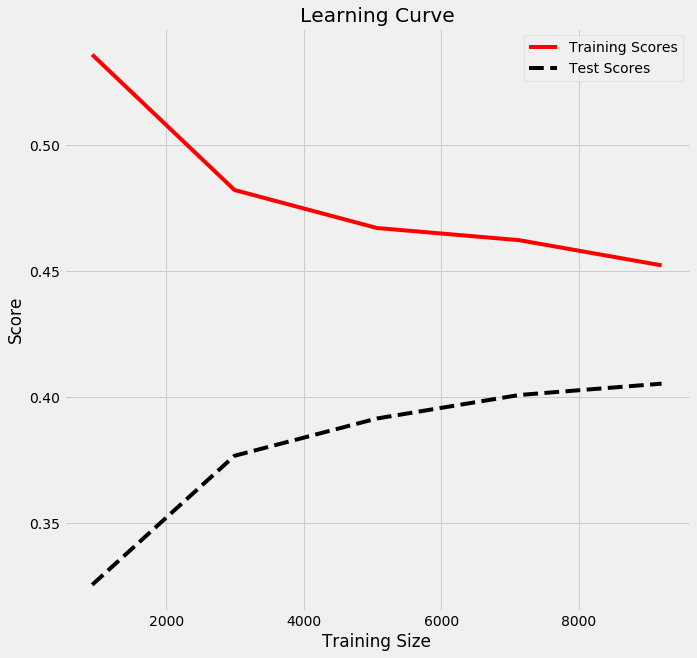

In [328]:
RI = Ridge(alpha = 5.9)
df_cv(RI, X_traini3, y_traini3, 10)

[0.17138513 0.16914173 0.16495895 0.16755059 0.17930604]
Mean: 0.1704684894565967
[0.48554108 0.46512509 0.46692841 0.49870052 0.45729056]
Mean: 0.4747171335060506
   train_size  train_score  test_score
0         818     0.875598    0.275174
1        2658     0.829292    0.380121
2        4499     0.800551    0.409779
3        6339     0.801055    0.445569
4        8180     0.801399    0.471293


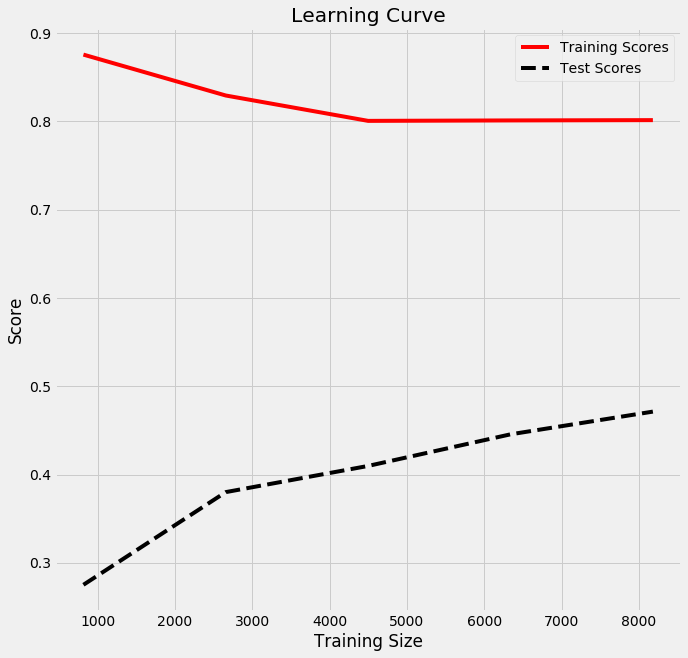

In [398]:
RF = ensemble.RandomForestRegressor(n_estimators= 20, max_depth= 20)
df_cv(RF, X_traini3, y_traini3, 5)

In [350]:

# models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
# models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
# models['randomForest'] = ensemble.RandomForestRegressor()
# models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
# models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()

models = [Ridge(7.3),
          SGDRegressor(loss = 'huber', l1_ratio=0),
          SGDRegressor(loss='epsilon_insensitive',l1_ratio = 0),
         ensemble.RandomForestRegressor()]
model_names = ['Ridge', 'huber', 'epsilon', 'randomforest']
cv_scores = []
for i, m in enumerate(models): 
    RI = m
    cv_scores.append((model_names[i], reg_cv_scores(RI, X_traini3, y_traini3, 10, False)));
cv_scores

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[('Ridge', (21.533747169263428, 0.360498187942824)),
 ('huber', (1687.7764597269029, -51.42639872188404)),
 ('epsilon', (7.820788865753074e+18, -2.1416503942461978e+17)),
 ('cart', (27.25759932658279, 0.19026105521288422)),
 ('extratrees', (27.657085454408577, 0.17743419675940117)),
 ('randomforst', (18.408915155430684, 0.4540978330341063)),
 ('adaboostedTrees', (31.149459508478394, 0.07499237628659318)),
 ('gradboostedTrees', (23.152814068758353, 0.31233499147152555))]

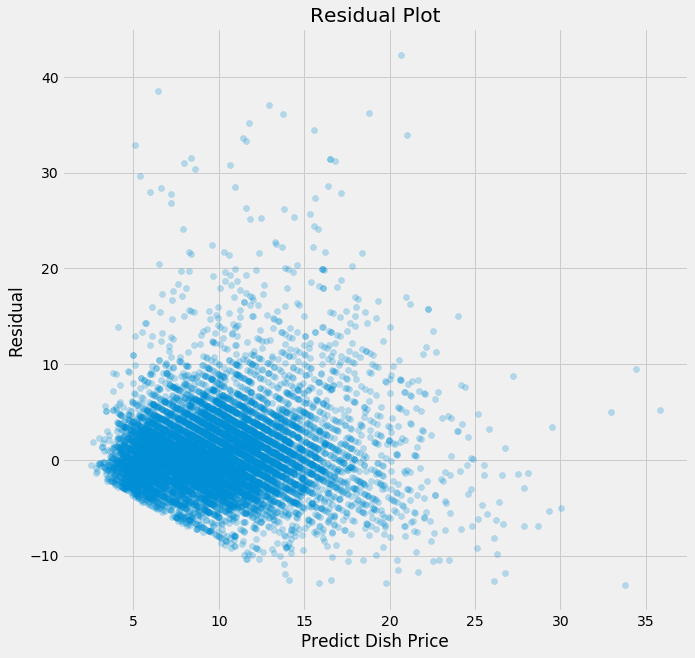

In [354]:
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
RI = Ridge(7.3)
RI.fit(X_traini3, y_traini3)
y_predict = RI.predict(X_traini3)
total_residual = np.exp(y_traini3) - np.exp(y_predict)
plt.scatter(np.exp(y_predict), total_residual, alpha=0.25)
plt.xlabel('Predict Dish Price')
plt.ylabel('Residual');
plt.title('Residual Plot');
#plt.savefig('Residual_Plot.png', format = 'png')

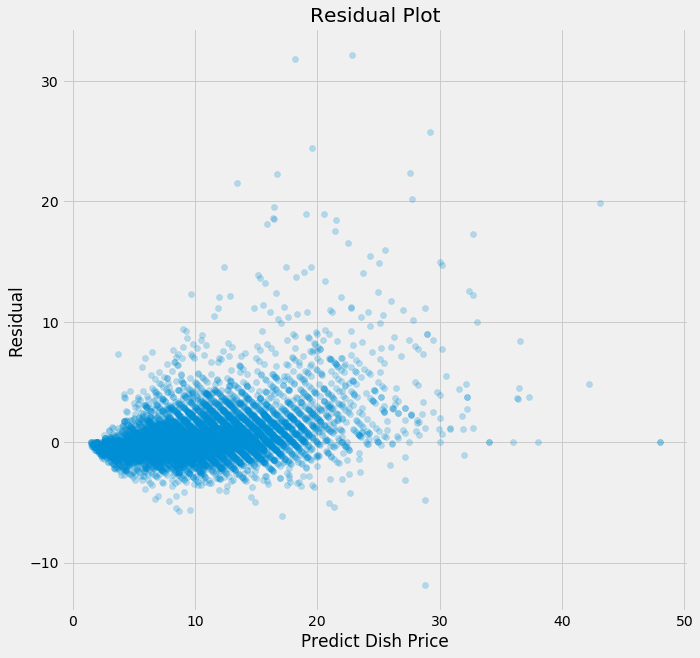

In [353]:
plt.rc('figure', figsize=(10.0, 10.0))
plt.style.use('fivethirtyeight')
RI = ensemble.RandomForestRegressor()
RI.fit(X_traini3, y_traini3)
y_predict = RI.predict(X_traini3)
total_residual = np.exp(y_traini3) - np.exp(y_predict)
plt.scatter(np.exp(y_predict), total_residual, alpha=0.25)
plt.xlabel('Predict Dish Price')
plt.ylabel('Residual');
plt.title('Residual Plot');
#plt.savefig('Residual_Plot.png', format = 'png')

In [815]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(total_residual, sm.add_constant(X_train))

(528.8487885920565,
 1.8024503098839819e-85,
 13.885879186924315,
 3.257404658888476e-89)

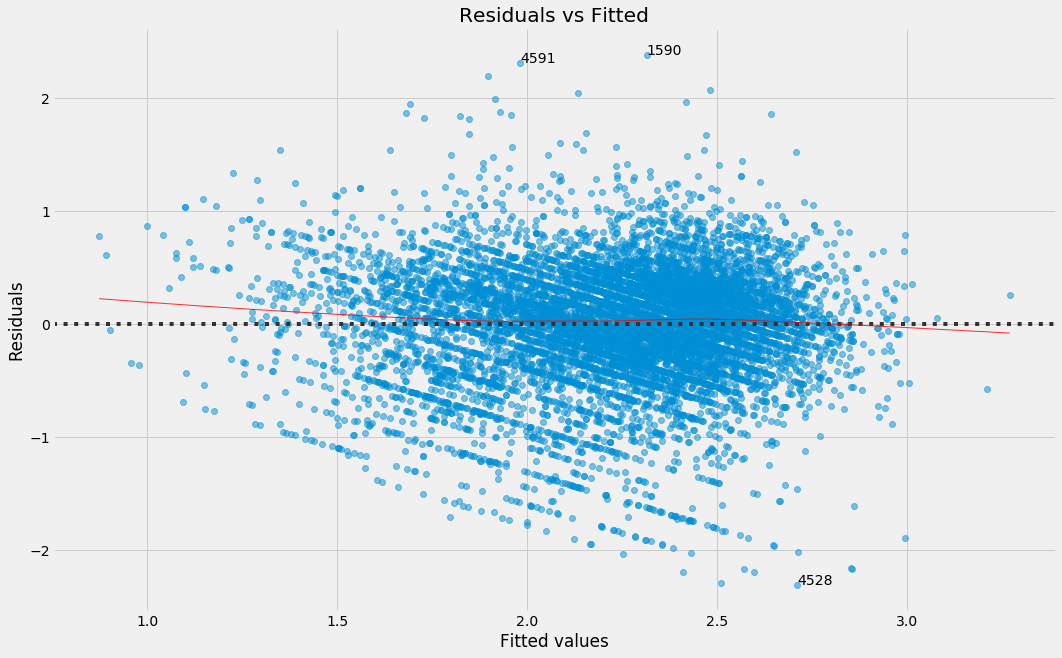

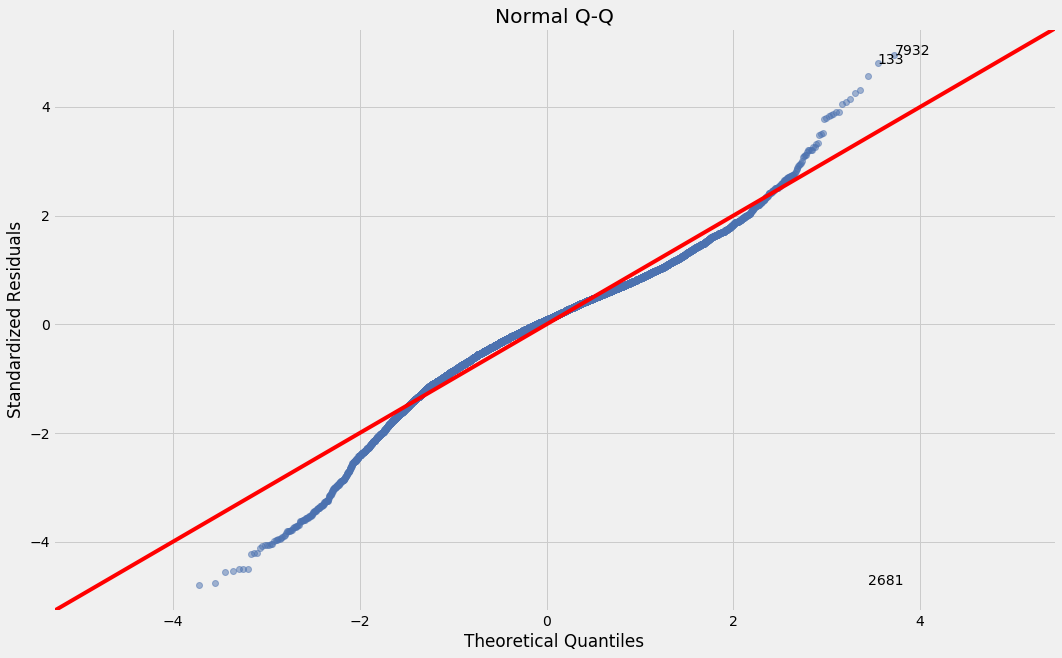

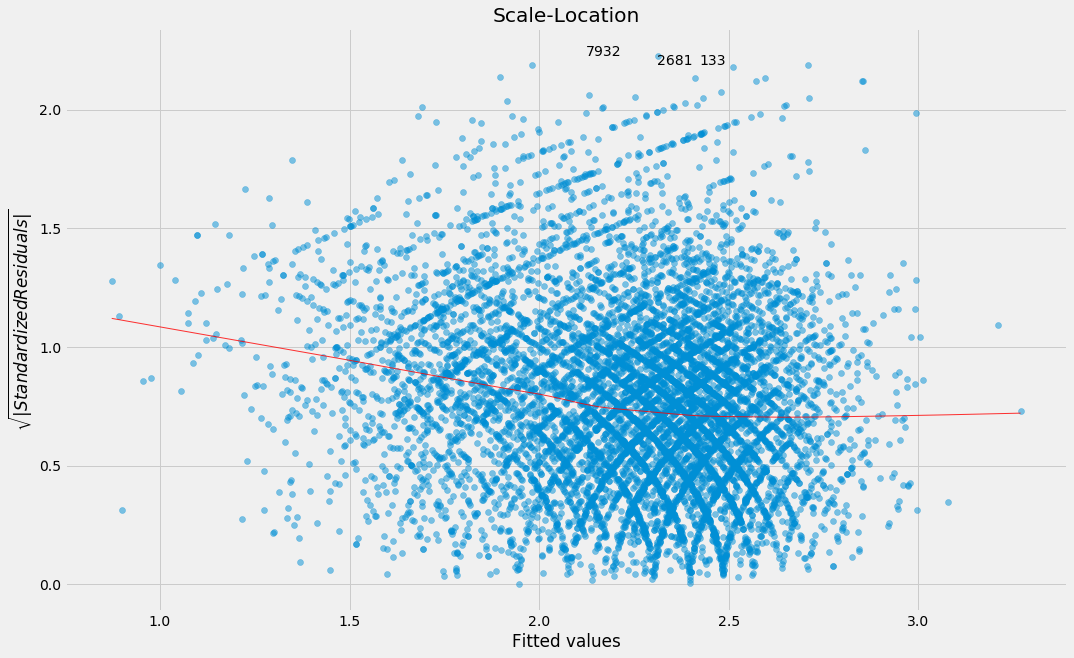

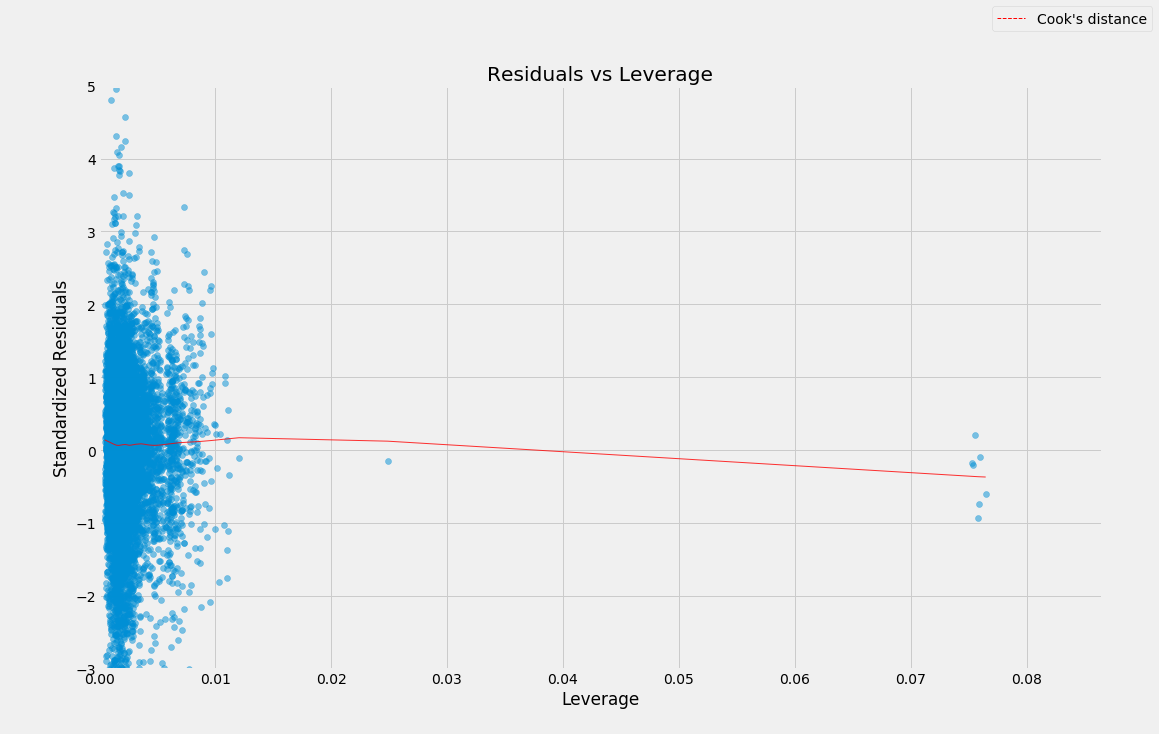

In [837]:
#a = X_train.iloc[4920].name
#X_train.drop(index = a, inplace = True)
#y_train.drop(index = a, inplace = True)
dp_plot.diagnostic_plots(sm.add_constant(X_train), y_train)